In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [3]:
credit_df = pd.read_csv("data/credit_df.csv")

In [125]:
credit_df

,CLIENT_ID,AGE,MAN,INCOME,IP_FLAG,SME_FLAG,REFUGEE_FLAG,PDN,paid_off_count,active_count,...,CT_708,CT_709,PC_GP Cross-Sale,PC_GP Direct,PC_GP External Refinance,PC_GP Refinance,PC_GP Top-Up,PC_Promo Beneficial Installment Loan,PC_Promo Rate Installment Loan,PC_Standard Installment Loan
0,23,33,1,80000,0,0,0,8.4,0,1,...,0,0,0,0,0,0,0,0,0,1
1,118,76,1,35000,0,0,0,8.3,0,1,...,0,0,0,0,0,0,0,0,0,1
2,271,42,1,120000,0,0,0,42.6,0,1,...,0,0,1,0,0,0,0,0,0,0
3,347,21,0,70000,0,0,0,41.9,0,1,...,0,0,0,0,0,0,0,0,0,1
4,706,66,1,37700,0,0,0,27.6,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3550,3099,43,1,41100,0,0,0,29.1,0,1,...,0,0,0,0,0,0,1,0,0,0
3551,3100,46,0,120000,0,0,0,22.0,0,1,...,0,0,1,0,0,0,0,0,0,0
3552,3101,60,0,45000,0,0,0,40.3,0,1,...,0,0,0,0,0,0,0,0,0,1
3553,3102,34,0,100000,0,0,0,56.2,1,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
X = credit_df.drop(columns=['delay', 'CLIENT_ID'])
y = credit_df.delay

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2844, 39) (711, 39) (2844,) (711,)


In [126]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3555 entries, 0 to 3554
Data columns (total 39 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   AGE                                   3555 non-null   int64  
 1   MAN                                   3555 non-null   int64  
 2   INCOME                                3555 non-null   int64  
 3   IP_FLAG                               3555 non-null   int64  
 4   SME_FLAG                              3555 non-null   int64  
 5   REFUGEE_FLAG                          3555 non-null   int64  
 6   PDN                                   3555 non-null   float64
 7   paid_off_count                        3555 non-null   int64  
 8   active_count                          3555 non-null   int64  
 9   active_sum                            3555 non-null   float64
 10  max_term                              3555 non-null   int64  
 11  credits_delay_cou

Дерево

In [5]:
%%time
dt_selector = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    {
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": range(1, 17),
        "min_samples_split": range(2, 17),
        "min_samples_leaf": range(1, 17),
    },
    cv=10,
    n_jobs=-1,
    verbose=2,
    n_iter=128,
)

dt_selector.fit(X_train, y_train)

print(dt_selector.best_estimator_.score(X_train, y_train),
      dt_selector.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 256 candidates, totalling 2560 fits
0.929324894514768 0.9029535864978903
CPU times: total: 2.11 s
Wall time: 22.1 s


In [6]:
dt_selector.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=7, min_samples_split=6,
                       random_state=42)

In [7]:
dt = DecisionTreeClassifier(random_state=42,
                            max_depth=5,
                            criterion="entropy")

dt.fit(X_train, y_train)
print(f"Train: {dt.score(X_train, y_train):.10f} | Test: {dt.score(X_test, y_test):.10f}")

Train: 0.9247538678 | Test: 0.9057665260


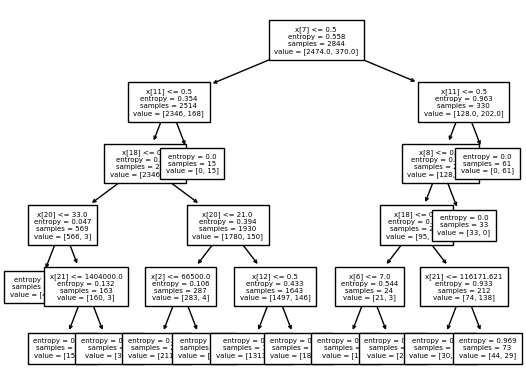

In [8]:
plot_tree(dt, fontsize=5);

In [9]:
pd.DataFrame({'Feature': X_train.columns, 'Importance': dt.feature_importances_}).sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
7,paid_off_count,0.569308
11,credits_delay_count,0.163819
18,MATRIAL_Неизвестно,0.092342
8,active_count,0.058771
21,ORIG_AMOUNT,0.038116
20,TERM,0.037309
12,cards_count,0.031049
6,PDN,0.006757
2,INCOME,0.002529
30,CT_709,0.000000


Лес

In [15]:
%%time
rf_selector = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, max_depth=6, criterion='entropy'),
    {
        #"criterion": ["gini", "entropy", "log_loss"],
        #"max_depth": range(1, 17),
        "n_estimators": range(8, 1024 + 1),
    },
    cv=5,
    n_jobs=-1,
    verbose=2,
    n_iter=16,
)

rf_selector.fit(X_train, y_train)

print(rf_selector.best_estimator_.score(X_train, y_train),
      rf_selector.best_estimator_.score(X_test, y_test))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
0.930379746835443 0.9127988748241913
CPU times: total: 2.88 s
Wall time: 49.7 s


In [16]:
rf_selector.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=997,
                       random_state=42)

In [17]:
rf = RandomForestClassifier(random_state=42,
                            max_depth=6,
                            n_estimators=1000,
                            criterion="entropy")

rf.fit(X_train, y_train)
print(f"Train: {rf.score(X_train, y_train):.10f} | Test: {rf.score(X_test, y_test):.10f}")

Train: 0.9300281294 | Test: 0.9127988748


In [19]:
pd.DataFrame(
    data=rf.feature_importances_,
    index=list(X),
    columns=["weight"]
).sort_values("weight", ascending=False).head(10)

,weight
paid_off_count,0.194838
active_sum,0.162219
active_count,0.152979
credits_delay_count,0.152882
MATRIAL_Неизвестно,0.050364
CURR_RATE_NVAL,0.037361
ORIG_AMOUNT,0.036898
PDN,0.030090
max_term,0.024174
TERM,0.022372


xgb

In [42]:
%%time
xg_selector = GridSearchCV(
    XGBClassifier(random_state=42, max_depth=2),
    {
        #"max_depth": range(1, 17),
        "n_estimators": range(90, 120),
    },
    cv=10,
    n_jobs=-1,
    verbose=2,
)

xg_selector.fit(X_train, y_train)

print(xg_selector.best_estimator_.score(X_train, y_train),
      xg_selector.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
0.9349507735583685 0.919831223628692
CPU times: total: 1.16 s
Wall time: 10.6 s


In [64]:
xgc = XGBClassifier(random_state=42, max_depth=2, n_estimators=113)
xgc.fit(X_train, y_train)

print(xgc.score(X_train, y_train), xgc.score(X_test, y_test))

0.9360056258790436 0.919831223628692


cb

In [51]:
%%time
cb_selector = GridSearchCV(
    CatBoostClassifier(random_state=42, verbose=0, iterations=256),
    {
        #"max_depth": range(1, 17),
        #"n_estimators": range(90, 120),
        "depth": range(2, 11),
    },
    cv=10,
    n_jobs=-1,
    verbose=2,
)

cb_selector.fit(X_train, y_train)

print(cb_selector.best_estimator_.score(X_train, y_train),
      cb_selector.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 9 candidates, totalling 90 fits
0.9739803094233473 0.909985935302391
CPU times: total: 3.92 s
Wall time: 1min 34s


In [59]:
cb = CatBoostClassifier(iterations=500, depth=5, verbose=0)
cb.fit(X_train, y_train)

print(cb.score(X_train, y_train), cb.score(X_test, y_test))

0.9440928270042194 0.9184247538677919


In [53]:
cb_selector.best_estimator_.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 256,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 9,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'lo

In [106]:
for lim in np.linspace(0.46, 0.52, 11):
    pred = []
    for f, t in xgc.predict_proba(X_test):
        if f > lim:
            pred.append(0)
        else:
            pred.append(1)

    print(f"{lim:.5f} | {accuracy_score(pred, y_test):.10f}")

0.46000 | 0.9170182841
0.46600 | 0.9184247539
0.47200 | 0.9198312236
0.47800 | 0.9198312236
0.48400 | 0.9198312236
0.49000 | 0.9198312236
0.49600 | 0.9198312236
0.50200 | 0.9198312236
0.50800 | 0.9198312236
0.51400 | 0.9198312236
0.52000 | 0.9184247539


In [74]:
xgc.predict_proba(X_test)

array([[0.99775565, 0.00224433],
       [0.9864657 , 0.01353428],
       [0.96457785, 0.03542214],
       ...,
       [0.92476404, 0.07523595],
       [0.95136476, 0.04863527],
       [0.9240689 , 0.07593106]], dtype=float32)

In [122]:
xgc.predict(X_test.iloc[29:30])

array([1])

,AGE,MAN,INCOME,IP_FLAG,SME_FLAG,REFUGEE_FLAG,PDN,paid_off_count,active_count,active_sum,...,CT_708,CT_709,PC_GP Cross-Sale,PC_GP Direct,PC_GP External Refinance,PC_GP Refinance,PC_GP Top-Up,PC_Promo Beneficial Installment Loan,PC_Promo Rate Installment Loan,PC_Standard Installment Loan
3034,38.0,0.0,200000.0,0.0,0.0,0.0,111.5,0.0,1.0,699048.4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
y_test[20:40]

2333    0
3034    1
414     0
457     0
1003    0
3540    1
134     1
70      0
1164    0
2421    1
3460    0
211     0
729     0
2223    0
2985    1
3309    1
2073    0
270     0
393     0
1840    0
Name: delay, dtype: int64

In [124]:
X_test.iloc[29:30].T

,2421
AGE,24.00
MAN,1.00
INCOME,68000.00
IP_FLAG,0.00
SME_FLAG,0.00
REFUGEE_FLAG,0.00
PDN,26.60
paid_off_count,1.00
active_count,0.00
active_sum,0.00


In [118]:
xgc.predict(X_test.iloc[20:40])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [108]:
joblib.dump(xgc, 'params/xgb_model.joblib')

['params/xgb_model.joblib']

In [117]:
model = joblib.load('params/xgb_model.joblib')
model.predict(X_test.iloc[20:40])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])